In [473]:
import os
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# from matplotlib.font_manager import fontManager
# fonts = [font.name for font in fontManager.ttflist if os.path.exists(font.fname)]
# for font in sorted(set(fonts)):
#     print(font)

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'

os.makedirs('./final_figs', exist_ok=True)

In [512]:
def get_outlier_mask(vector, percentile=100-1):
    threshold = np.percentile(vector, percentile)
    return vector > threshold

def plot_vector(
    vector,
    title,
    save_path,
    group_size = 32,
    num_group_per_tick = 32,
    tick_begin = 0,
    threshold = None,
    ylim = None,
    set_ylabel = False,
    ax = None,
    legend = False,
    is_zoom = False,
):
    orig_shape = vector.shape  # 8192, 22016 (21.5 * 1024)
    if threshold is None:
        mid_magnitude = np.percentile(vector, 50)
        threshold = mid_magnitude * 2
    total_is_salient = (vector > threshold).sum()
    total_channel = vector.shape[0]

    num_group = orig_shape[0] // group_size
    vector = torch.cat([vector, torch.zeros(group_size - (orig_shape[0] % group_size))], dim=0)
    vector = vector.view(-1, group_size).max(dim=1)[0]
    group_idx = np.arange(vector.shape[0])

    if ax is None:
        fig, ax = plt.subplots(figsize=(len(group_idx)*0.02, 3))
    
    # 按照我们对outlier的定义搞一下
    is_salient = vector > threshold
    # colors = ['C3' if is_salient[i] else 'C0' for i in range(len(vector))]

    # plot bar
    colormap = mpl.colormaps['RdBu']
    salient_color = colormap(0.1)
    # salient_color = 'C3'
    normal_color = colormap(0.9)
    # normal_color = 'C0'
    ax.bar(group_idx[is_salient], vector[is_salient], color=salient_color, alpha=1, label='Salient')
    ax.bar(group_idx[~is_salient], vector[~is_salient], color=normal_color, alpha=1, label='Normal')

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Channel', fontsize=10)
    ax.set_xticks(np.arange(0, len(group_idx) + 1, num_group_per_tick), np.arange(0, orig_shape[0] + 1, num_group_per_tick * group_size) + tick_begin, rotation=30)
    if set_ylabel:
        ax.set_ylabel('Magnitude', fontsize=10)
    if ylim:
        ax.set_ylim(ylim)
    if legend:
        ax.legend(loc='center right')

    if not is_zoom: # large graph
        ax.text(0.05, 0.95, f"#Salient: {total_is_salient} / {total_channel}", transform=ax.transAxes, verticalalignment='top', fontsize=10)
    else: # zoom graph
        ax.text(0.12, 0.95, f"#Salient: \n{total_is_salient:>7} / {total_channel}", transform=ax.transAxes, verticalalignment='top', fontsize=10)


    if save_path:
        plt.savefig(save_path)

def analyze_outlier_statistics(vector):
    """
    Find activation group with most / minimum outlier channels
    """
    mid_magnitude = np.percentile(vector, 50)
    print(mid_magnitude)
    is_salient = vector > (mid_magnitude * 2)
    group_size = 128
    num_outlier = is_salient.view(-1, group_size).sum(dim=-1)

    # find max / min outlier group
    max_idx = num_outlier.argmax().item()
    min_idx = num_outlier.argmin().item()
    print("idx", max_idx, min_idx)

    max_val = num_outlier.max().item()
    min_val = num_outlier.min().item()
    print("val", max_val, min_val)

    return max_idx, min_idx, max_val, min_val

In [513]:
# outlier_stats = torch.load('outlier_stats/3_sigma/llama-65b-meta_outlier.pt')
# outlier_stats = torch.load('outlier_stats/3_sigma/opt-6.7b_outlier.pt')
outlier_stats = torch.load('act_stats/llama-65b-meta.pt')

# for k, v in outlier_stats.items():
#     print(k)

LAYER_ID = 12
# llama
layers = {
    f"model.layers.{LAYER_ID}.input_layernorm": 'Attention Input Projection Layer',
    f"model.layers.{LAYER_ID}.post_attention_layernorm": 'FFN Expansion Layer',
    f"model.layers.{LAYER_ID}.self_attn.o_proj": 'Attention Output Projection Layer',
    f"model.layers.{LAYER_ID}.mlp.down_proj": 'FFN Contraction Layer',
}

fig_titles = {
    f"model.layers.{LAYER_ID}.input_layernorm": 'attn_iproj',
    f"model.layers.{LAYER_ID}.post_attention_layernorm": 'mlp_fc1',
    f"model.layers.{LAYER_ID}.self_attn.o_proj": 'attn_oproj',
    f"model.layers.{LAYER_ID}.mlp.down_proj": 'mlp_fc2',
}

# opt
# layers = [
#     f"model.decoder.layers.{LAYER_ID}.self_attn_layer_norm",
#     f"model.decoder.layers.{LAYER_ID}.self_attn.out_proj",
#     f"model.decoder.layers.{LAYER_ID}.final_layer_norm",
#     f"model.decoder.layers.{LAYER_ID}.fc2",
# ]

# choose layers to plot
# layers = [
#     f"model.layers.{i}.self_attn.o_proj" for i in range(32)
#     # f"model.layers.{i}.mlp.down_proj" for i in range(32)
# ]



0.99365234375
idx 23 2
val 4 0
1.724609375
idx 70 102
val 23 6


/tmp/ipykernel_1605/353614652.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


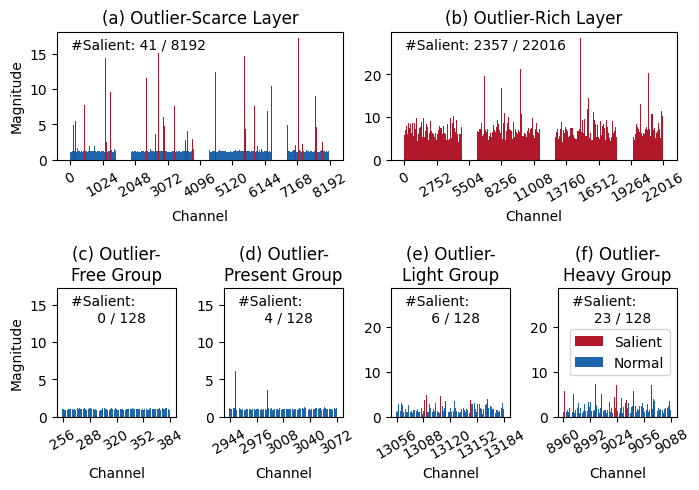

In [515]:
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=1, wspace=0.4)

os.makedirs('./final_figs_v2', exist_ok=True)

grids = [
    gs[1, 0],
    gs[1, 1],
    gs[0, 0:2],
    
    gs[1, 2],
    gs[1, 3],
    gs[0, 2:4],
]
grid_cnt = 0

for layer_name in layers:
    category = 'abs_output' if 'norm' in layer_name else 'abs_input'
    outlier_magnitude = outlier_stats[layer_name][category]['max']
    # in detail
    zoom_group_size = 128

    if 'input_layernorm' in layer_name:
        max_idx, min_idx, max_val, min_val = analyze_outlier_statistics(outlier_magnitude)
        threshold = np.percentile(outlier_magnitude, 50) * 2
        ylim = (0, max(outlier_magnitude) * 1)
        # ylim = (0, 10)

        ax = fig.add_subplot(grids[grid_cnt])
        grid_cnt += 1
        tick_begin = min_idx * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            title="(c) Outlier-\nFree Group",
            save_path=None,
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            set_ylabel=True,
            ylim=ylim,
            ax=ax,
            is_zoom=True,
        )

        ax = fig.add_subplot(grids[grid_cnt])
        grid_cnt += 1
        tick_begin = max_idx * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            title="(d) Outlier-\nPresent Group",
            save_path=None,
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            set_ylabel=False,
            ylim=ylim,
            ax=ax,
            is_zoom=True,
        )

        ax = fig.add_subplot(grids[grid_cnt])
        grid_cnt += 1
        plot_vector(
            outlier_magnitude,
            # title=layers[layer_name],
            title="(a) Outlier-Scarce Layer",
            save_path=None,
            ax=ax,
            set_ylabel=True,
        )

    elif 'down_proj' in layer_name:
        max_idx, min_idx, max_val, min_val = analyze_outlier_statistics(outlier_magnitude)
        threshold = np.percentile(outlier_magnitude, 50) * 2
        ylim = (0, max(outlier_magnitude) * 1)
        # ylim = (0, 10)

        ax = fig.add_subplot(grids[grid_cnt])
        grid_cnt += 1
        tick_begin = min_idx * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            title="(e) Outlier-\nLight Group",
            save_path=None,
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            set_ylabel=False,
            ylim=ylim,
            ax=ax,
            is_zoom=True,
        )
        
        ax = fig.add_subplot(grids[grid_cnt])
        grid_cnt += 1
        tick_begin = max_idx * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            title="(f) Outlier-\nHeavy Group",
            save_path=None,
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            set_ylabel=False,
            ylim=ylim,
            ax=ax,
            legend=True,
            is_zoom=True,
        )

        ax = fig.add_subplot(grids[grid_cnt])
        grid_cnt += 1 
        plot_vector(
            outlier_magnitude,
            # title=layers[layer_name],
            title="(b) Outlier-Rich Layer",
            save_path=None,
            group_size=86,
            ax=ax,
            set_ylabel=False,
        )

fig.align_labels()
fig.tight_layout()
plt.savefig('final_figs_v2/act_distribution.pdf')

0.99365234375
idx 23 2
val 4 0
1.0634765625
idx 17 0
val 9 0
1.724609375
idx 70 102
val 23 6


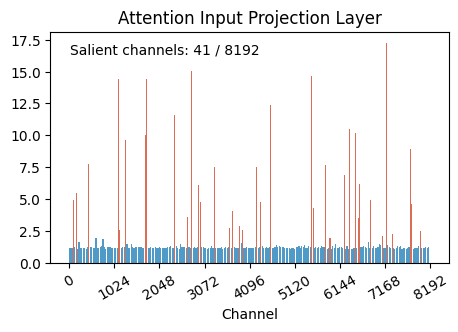

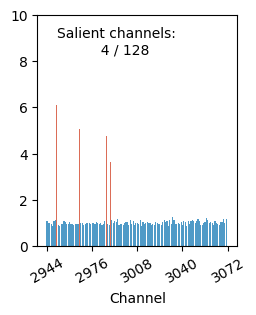

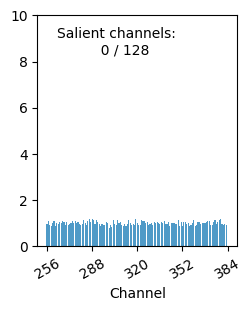

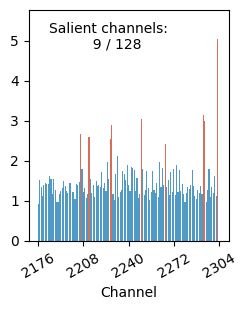

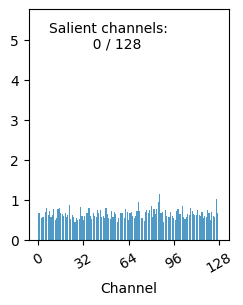

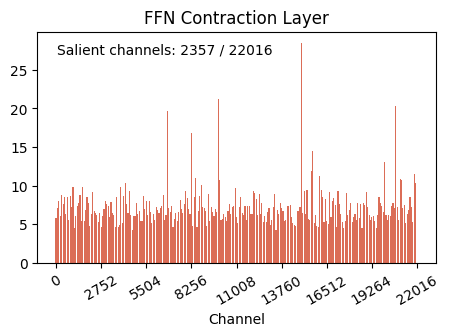

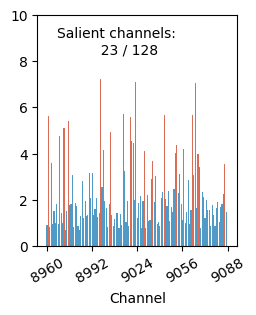

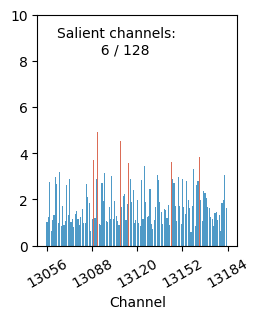

In [465]:
os.makedirs('./final_figs_v2', exist_ok=True)

for layer_name in layers:
    # category = 'output' if 'norm' in layer_name else 'input'
    category = 'abs_output' if 'norm' in layer_name else 'abs_input'
    outlier_magnitude = outlier_stats[layer_name][category]['max']

    if 'down_proj' in layer_name:
        plot_vector(
            outlier_magnitude,
            title=layers[layer_name],
            # title=layer_name,
            save_path=f"final_figs_v2/{fig_titles[layer_name]}.pdf",
            # save_path=f"final_figs_v2/{layer_name}.pdf",
            group_size=86,
        )
    elif 'input_layernorm' in layer_name:
        plot_vector(
            outlier_magnitude,
            title=layers[layer_name],
            # title=layer_name,
            save_path=f"final_figs_v2/{fig_titles[layer_name]}.pdf",
            # save_path=f"final_figs_v2/{layer_name}.pdf",
        )

    # in detail
    zoom_group_size = 128

    if 'input_layernorm' in layer_name:
        analyze_outlier_statistics(outlier_magnitude)
        threshold = np.percentile(outlier_magnitude, 50) * 2
        ylim = (0, 10)

        tick_begin = 23 * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            # title=layers[layer_name],
            # title=layer_name,
            title=None,
            save_path=f"final_figs_v2/{fig_titles[layer_name]}_zoom1.pdf",
            # save_path=f"final_figs_v2/{layer_name}_detail1.pdf",
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            is_zoom=True,
            ylim=ylim,
        )

        tick_begin = 2 * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            # title=layers[layer_name],
            # title=layer_name,
            title=None,
            save_path=f"final_figs_v2/{fig_titles[layer_name]}_zoom2.pdf",
            # save_path=f"final_figs_v2/{layer_name}_detail1.pdf",
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            is_zoom=True,
            ylim=ylim,
        )

    elif 'o_proj' in layer_name:
        analyze_outlier_statistics(outlier_magnitude)
        threshold = np.percentile(outlier_magnitude, 50) * 2
        ylim = (0, outlier_magnitude.max())

        tick_begin = 17 * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            # title=layers[layer_name],
            # title=layer_name,
            title=None,
            save_path=f"final_figs_v2/{fig_titles[layer_name]}_zoom1.pdf",
            # save_path=f"final_figs_v2/{layer_name}_detail1.pdf",
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            is_zoom=True,
            ylim=ylim,
        )

        tick_begin = 0 * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            # title=layers[layer_name],
            # title=layer_name,
            title=None,
            save_path=f"final_figs_v2/{fig_titles[layer_name]}_zoom2.pdf",
            # save_path=f"final_figs_v2/{layer_name}_detail1.pdf",
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            is_zoom=True,
            ylim=ylim,
        )


    elif 'down_proj' in layer_name:
        analyze_outlier_statistics(outlier_magnitude)
        threshold = np.percentile(outlier_magnitude, 50) * 2
        ylim = (0, 10)

        tick_begin = 70 * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            # title=layers[layer_name],
            # title=layer_name,
            title=None,
            save_path=f"final_figs_v2/{fig_titles[layer_name]}_zoom1.pdf",
            # save_path=f"final_figs_v2/{layer_name}_detail1.pdf",
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            is_zoom=True,
            ylim=ylim,
        )

        tick_begin = 102 * zoom_group_size
        plot_vector(
            outlier_magnitude[tick_begin:tick_begin + zoom_group_size],
            # title=layers[layer_name],
            # title=layer_name,
            title=None,
            save_path=f"final_figs_v2/{fig_titles[layer_name]}_zoom2.pdf",
            # save_path=f"fin al_figs_v2/{layer_name}_detail2.pdf",
            group_size=1,
            tick_begin=tick_begin,
            threshold=threshold,
            is_zoom=True,
            ylim=ylim,
        )


        # for i, tick_begin in enumerate(range(0, 22016, 1024)):
        #     plot_vector(
        #         outlier_magnitude[tick_begin:tick_begin + 1024],
        #         # title=layers[layer_name],
        #         # title=layer_name,
        #         title=None,
        #         # save_path=f"final_figs_v2/{fig_titles[layer_name]}_mask.pdf",
        #         save_path=f"final_figs_v2/{layer_name}_test_{i}.pdf",
        #         group_size=1,
        #         tick_begin=tick_begin,
        #         ylim=(0, 10),
        #     )

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('results/outlier_dse.csv')
print(df)

             model                experiment  wikitext2
0    llama-7b-meta                 fc1_W16A4       8.37
1    llama-7b-meta     fc1_W16A4O12_ol1p1024       5.89
2    llama-7b-meta      fc1_W16A4O12_ol1p128       5.79
3    llama-7b-meta       fc1_W16A4O12_ol1p16       5.78
4    llama-7b-meta     fc1_W16A4O12_ol1p2048       6.00
..             ...                       ...        ...
243       opt-6.7b    qkvproj_W16A4O8_ol1p32      12.54
244       opt-6.7b  qkvproj_W16A4O8_ol1p4096     345.31
245       opt-6.7b   qkvproj_W16A4O8_ol1p512      13.14
246       opt-6.7b    qkvproj_W16A4O8_ol1p64      12.55
247       opt-6.7b     qkvproj_W16A4O8_ol1p8      12.52

[248 rows x 3 columns]


In [34]:
def parse_experiment_name(name):
    pattern = r'ol1p(\d+)'
    match = re.search(pattern, name)
    if match:
        outlier_ratio = int(match.group(1))
    else:
        outlier_ratio = 0

    pattern = r'W16A4O(\d+)'
    match = re.search(pattern, name)
    if match:
        outlier_precision = int(match.group(1))
    else:
        outlier_precision = 4

    layer_type = name.split('_')[0]
    
    return outlier_ratio, outlier_precision, layer_type

# Add two new columns to df: outlier ratio and outlier precision
df['outlier_ratio'] = 0
df['outlier_precision'] = 0
df['layer_type'] = 0

# for every row in df, parse the experiment name and update the two new columns
for i in range(len(df)):
    outlier_ratio, outlier_precision, layer_type = parse_experiment_name(df['experiment'][i])
    df['outlier_ratio'][i] = outlier_ratio
    df['outlier_precision'][i] = outlier_precision
    df['layer_type'][i] = layer_type

/tmp/ipykernel_48195/1653741344.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_ratio'][i] = outlier_ratio
/tmp/ipykernel_48195/1653741344.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_precision'][i] = outlier_precision
/tmp/ipykernel_48195/1653741344.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['layer_type'][i] = layer_type
/tmp/ipykernel_48195/1653741344.py:30: FutureWarning: Setting an 

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


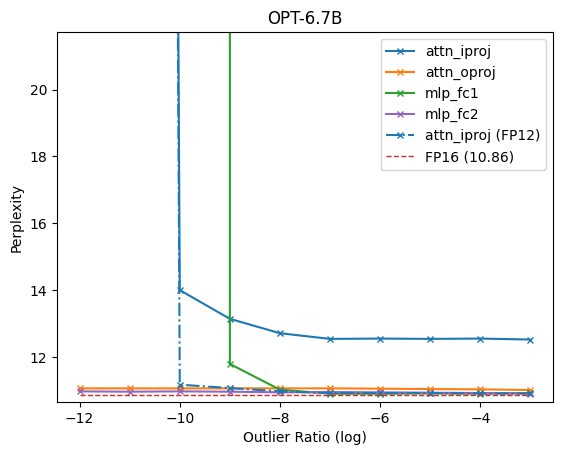

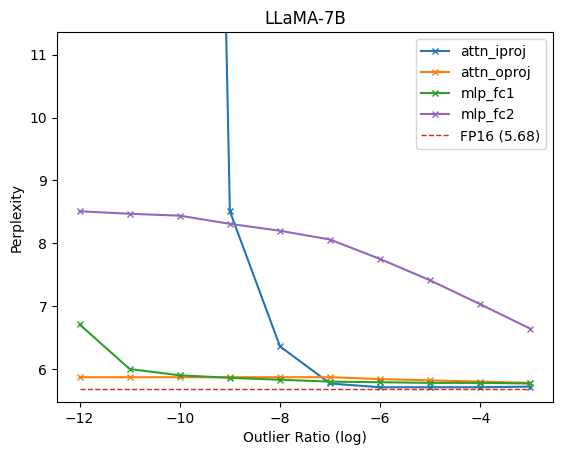

In [73]:
# First, we only plot 16 bits result to show the trend

layer_types = {
    'qkvproj': 'attn_iproj',
    'oproj': 'attn_oproj',
    'fc1': 'mlp_fc1',
    'fc2': 'mlp_fc2',
}
layer_type_colors = {
    layer_type: color for layer_type, color in zip(layer_types, ['C0', 'C1', 'C2', 'C4'])
}
outlier_precisions = [
    8,
    # 12,
    # 16,
]
models = {
    'opt-6.7b': 'OPT-6.7B',
    'llama-7b-meta': 'LLaMA-7B',
}
model_fp16_ppl = {
    'opt-6.7b': 10.86,
    'llama-7b-meta': 5.68,
}

for model in models:
    for layer_type in layer_types:
        for outlier_precision in outlier_precisions:
            df1 = df[df['layer_type'] == layer_type]
            df1 = df1[df1['outlier_precision'] == outlier_precision]
            df1 = df1[df1['model'] == model]
            # sort df1 by outlier ratio
            df1 = df1.sort_values(by=['outlier_ratio'])

            outlier_ratio_list = -1 * np.log2(df1['outlier_ratio'])
            ppl_list = df1['wikitext2']
            color = layer_type_colors[layer_type]

            plt.plot(outlier_ratio_list, ppl_list, 'x-', markersize=5, color=color, label=f'{layer_types[layer_type]}')

    # draw an extra line for opt qkvproj 12bit
    if model == 'opt-6.7b':
        df1 = df[df['layer_type'] == 'qkvproj']
        df1 = df1[df1['outlier_precision'] == 12]
        df1 = df1[df1['model'] == model]
        # sort df1 by outlier ratio
        df1 = df1.sort_values(by=['outlier_ratio'])

        outlier_ratio_list = -1 * np.log2(df1['outlier_ratio'])
        ppl_list = df1['wikitext2']
        color = layer_type_colors['qkvproj']

        plt.plot(outlier_ratio_list, ppl_list, 'x-.', markersize=5, color=color, label=f'{layer_types["qkvproj"]} (FP12)')

    # draw a horizontal line of model ppl
    fp16_ppl = model_fp16_ppl[model]
    plt.plot((-12, -3), [fp16_ppl, fp16_ppl], '--', linewidth=1, color='C3', label=f'FP16 ({fp16_ppl})')
    plt.ylim(fp16_ppl-0.2, 2*fp16_ppl)

    plt.xlabel('Outlier Ratio (log)')
    plt.ylabel('Perplexity')
    plt.title(f'{models[model]}')
    plt.legend(loc='upper right')

    plt.savefig(f'final_figs/outlier_dse_{models[model]}.pdf')
    plt.show()

In [21]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import torch

df = pd.read_csv('results/outlier_dse_v2.csv')
print(df)

            model               experiment  wikitext2
0   llama-7b-meta          fc1_W16A4O8_ot1       5.74
1   llama-7b-meta       fc1_W16A4O8_ot1.25       5.80
2   llama-7b-meta        fc1_W16A4O8_ot1.5       5.81
3   llama-7b-meta          fc1_W16A4O8_ot2       5.83
4   llama-7b-meta          fc1_W16A4O8_ot3       5.92
5   llama-7b-meta          fc2_W16A4O8_ot1       5.92
6   llama-7b-meta       fc2_W16A4O8_ot1.25       6.14
7   llama-7b-meta        fc2_W16A4O8_ot1.5       6.37
8   llama-7b-meta          fc2_W16A4O8_ot2       6.84
9   llama-7b-meta          fc2_W16A4O8_ot3       7.61
10  llama-7b-meta        oproj_W16A4O8_ot1       5.72
11  llama-7b-meta     oproj_W16A4O8_ot1.25       5.78
12  llama-7b-meta      oproj_W16A4O8_ot1.5       5.82
13  llama-7b-meta        oproj_W16A4O8_ot2       5.86
14  llama-7b-meta        oproj_W16A4O8_ot3       5.88
15  llama-7b-meta     qkvproj_W16A4O12_ot1       5.69
16  llama-7b-meta  qkvproj_W16A4O12_ot1.25       5.70
17  llama-7b-meta   qkvproj_

In [22]:
def parse_experiment_name(name):
    pattern = r'ot(\d+(\.\d+)?)'
    match = re.search(pattern, name)
    if match:
        outlier_threshold = float(match.group(1))
    else:
        outlier_threshold = 0


    pattern = r'W16A4O(\d+)'
    match = re.search(pattern, name)
    if match:
        outlier_precision = int(match.group(1))
    else:
        outlier_precision = 4

    layer_type = name.split('_')[0]
    
    return outlier_threshold, outlier_precision, layer_type

# Add two new columns to df: outlier ratio and outlier precision
df['outlier_threshold'] = 0
df['outlier_precision'] = 0
df['layer_type'] = 0

# for every row in df, parse the experiment name and update the two new columns
for i in range(len(df)):
    outlier_threshold, outlier_precision, layer_type = parse_experiment_name(df['experiment'][i])
    df['outlier_threshold'][i] = outlier_threshold
    df['outlier_precision'][i] = outlier_precision
    df['layer_type'][i] = layer_type

/tmp/ipykernel_1605/1149645110.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_threshold'][i] = outlier_threshold
/tmp/ipykernel_1605/1149645110.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_precision'][i] = outlier_precision
/tmp/ipykernel_1605/1149645110.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['layer_type'][i] = layer_type
/tmp/ipykernel_1605/1149645110.py:31: FutureWarning: Setting

In [23]:
df

,model,experiment,wikitext2,outlier_threshold,outlier_precision,layer_type
0,llama-7b-meta,fc1_W16A4O8_ot1,5.74,1.00,8,fc1
1,llama-7b-meta,fc1_W16A4O8_ot1.25,5.80,1.25,8,fc1
2,llama-7b-meta,fc1_W16A4O8_ot1.5,5.81,1.50,8,fc1
3,llama-7b-meta,fc1_W16A4O8_ot2,5.83,2.00,8,fc1
4,llama-7b-meta,fc1_W16A4O8_ot3,5.92,3.00,8,fc1
5,llama-7b-meta,fc2_W16A4O8_ot1,5.92,1.00,8,fc2
6,llama-7b-meta,fc2_W16A4O8_ot1.25,6.14,1.25,8,fc2
7,llama-7b-meta,fc2_W16A4O8_ot1.5,6.37,1.50,8,fc2
8,llama-7b-meta,fc2_W16A4O8_ot2,6.84,2.00,8,fc2
9,llama-7b-meta,fc2_W16A4O8_ot3,7.61,3.00,8,fc2


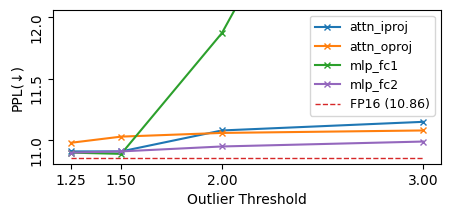

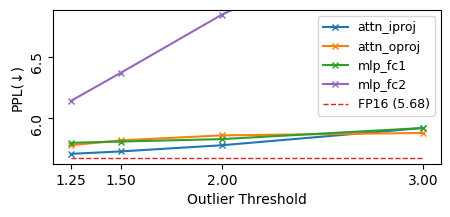

In [51]:
# First, we only plot 16 bits result to show the trend

layer_types = {
    'qkvproj': 'attn_iproj',
    'oproj': 'attn_oproj',
    'fc1': 'mlp_fc1',
    'fc2': 'mlp_fc2',
}
layer_type_colors = {
    layer_type: color for layer_type, color in zip(layer_types, ['#B2D6E6','#485BAA', ''])
}
outlier_precisions = [
    8,
    12,
    # 16,
]
models = {
    'opt-6.7b': 'OPT-6.7B',
    'llama-7b-meta': 'LLaMA-7B',
}
model_fp16_ppl = {
    'opt-6.7b': 10.86,
    'llama-7b-meta': 5.68,
}

for model in models:
    plt.figure(figsize=(5, 2))
    
    for layer_type in layer_types:
        for outlier_precision in outlier_precisions:
            if model == 'opt-6.7b' and layer_type == 'qkvproj':
                if outlier_precision != 12:
                    continue
            else:
                if outlier_precision != 8:
                    continue
            df1 = df[df['layer_type'] == layer_type]
            df1 = df1[df1['outlier_precision'] == outlier_precision]
            df1 = df1[df1['model'] == model]
            # sort df1 by outlier ratio
            df1 = df1.sort_values(by=['outlier_threshold'])
            outlier_threshold_list = df1['outlier_threshold']
            ppl_list = df1['wikitext2']
            color = layer_type_colors[layer_type]

            plt.plot(outlier_threshold_list[1:], ppl_list[1:], 'x-', markersize=5, color=color, label=f'{layer_types[layer_type]}')

    # draw a horizontal line of model ppl
    fp16_ppl = model_fp16_ppl[model]
    plt.plot((1.25,3), [fp16_ppl, fp16_ppl], '--', linewidth=1, color='C3', label=f'FP16 ({fp16_ppl})')
    
    plt.xticks([1.25, 1.5, 2, 3])

    if model == 'opt-6.7b':
        plt.ylim(fp16_ppl-0.05, fp16_ppl+1.2)
        plt.yticks(np.arange(11, 12.25, 0.5), rotation=90)
    else:
        plt.ylim(fp16_ppl-0.05, fp16_ppl+1.2)
        plt.yticks(np.arange(6, 7, 0.5), rotation=90)

    plt.xlabel('Outlier Threshold')
    plt.ylabel('PPL(↓)')
    # plt.title(f'{models[model]}')
    plt.legend(loc='upper right', fontsize=9)

    plt.savefig(f'final_figs/outlier_dse_{models[model]}.pdf')
    plt.show()

{'qkvproj': -1.0, 'oproj': -1.0, 'fc1': -1.0, 'fc2': -1.0}
{'qkvproj': -2.0113153, 'oproj': -1.2227447, 'fc1': -4.0574856, 'fc2': -1.5866672}
{'qkvproj': -2.9638264, 'oproj': -1.4310938, 'fc1': -6.117357, 'fc2': -2.120203}
{'qkvproj': -4.492205, 'oproj': -2.6579254, 'fc1': -7.0, 'fc2': -3.170056}
{'qkvproj': -5.6076827, 'oproj': -6.445411, 'fc1': -7.5405684, 'fc2': -4.7189054}


Text(0, 0.5, 'Salient Ratio (log)')

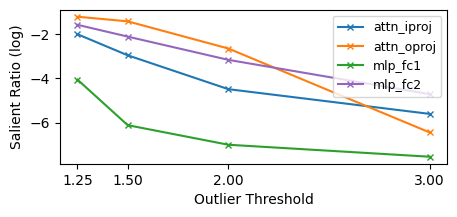

In [52]:
df_threshold = pd.DataFrame(columns=['threshold', 'qkvproj', 'oproj', 'fc1', 'fc2'])

outlier_stats = torch.load('act_stats/llama-7b-meta.pt')

layer_type_cast = {
    'q_proj': 'qkvproj',
    'k_proj': 'qkvproj',
    'v_proj': 'qkvproj',
    'o_proj': 'oproj',
    'up_proj': 'fc1',
    'gate_proj': 'fc1',
    'down_proj': 'fc2',
}

outlier_stats = {k: v for k, v in outlier_stats.items() if not 'norm' in k and not 'matmul' in k}
# outlier_stats = {k: v for k, v in outlier_stats.items() if 'input_layernorm' in k}
# outlier_stats = {k: v for k, v in outlier_stats.items() if 'post_attention_layernorm' in k}
# outlier_stats = {k: v for k, v in outlier_stats.items() if 'self_attn_layer_norm' in k}
# outlier_stats = {k: v for k, v in outlier_stats.items() if 'final_layer_norm' in k}

output_scales = []

for threshold in [1, 1.25, 1.5, 2, 3]:
    layer_type_ratios = {
        'qkvproj': [],
        'oproj': [],
        'fc1': [],
        'fc2': [],
    }

    for module_name, layer_stats in outlier_stats.items():
        input_stats = layer_stats['input']
        input_scale = input_stats['max'] - input_stats['min']
        input_scale_mean = input_scale.mean()
        input_scale_std = input_scale.std()
        input_scale_mid = np.percentile(input_scale, 50)

        # threshold = input_scale_mean * 2
        # threshold = input_scale_mid  * 1.25
        input_scale = input_scale / input_scale_mid

        salient_mask = input_scale > threshold
        salient_ratio = salient_mask.sum() / len(salient_mask)
        # log_salient_ratio = np.log2(salient_ratio)
        # print(module_name, f"salient ratio: {log_salient_ratio:.2f}")
        # print(module_name, f"std / mean: {input_scale_std / input_scale_mean:.2f}")

        layer_type = layer_type_cast[module_name.split('.')[-1]]
        layer_type_ratios[layer_type].append(salient_ratio)

    # get average salient ratio for each layer type
    for layer_type in layer_type_ratios:
        mean_ratio = np.max(layer_type_ratios[layer_type])
        log2_mean_ratio = np.log2(mean_ratio)
        layer_type_ratios[layer_type] = log2_mean_ratio
    print(layer_type_ratios)

    layer_type_ratios['threshold'] = threshold

    df_threshold.loc[len(df_threshold)] = layer_type_ratios

plt.figure(figsize=(5, 2))

for layer_type in layer_types:
    if layer_type == 'threshold':
        continue
    plt.plot(df_threshold['threshold'][1:], df_threshold[layer_type][1:], 'x-', markersize=5, color=layer_type_colors[layer_type], label=f'{layer_types[layer_type]}')
plt.legend(fontsize=9)
plt.xticks([1.25, 1.5, 2, 3])
plt.xlabel('Outlier Threshold')
plt.ylabel('Salient Ratio (log)')


In [49]:
for model in models:
    if model != 'llama-7b-meta': continue

    # draw an extra line for opt qkvproj 12bit
    if model == 'opt-6.7b':
        df1 = df[df['layer_type'] == 'qkvproj']
        df1 = df1[df1['outlier_precision'] == 12]
        df1 = df1[df1['model'] == model]
        # sort df1 by outlier ratio
        df1 = df1.sort_values(by=['outlier_threshold'])

        outlier_threshold_list = df1['outlier_threshold']
        ppl_list = df1['wikitext2']
        ppl_list.index = range(len(ppl_list))

        df_threshold[f'{layer_type}_ppl'] = ppl_list

    for layer_type in layer_types:
        for outlier_precision in outlier_precisions:
            if model == 'opt-6.7b' and layer_type == 'qkvproj' and outlier_precision == 8:
                continue
            df1 = df[df['layer_type'] == layer_type]
            df1 = df1[df1['outlier_precision'] == outlier_precision]
            df1 = df1[df1['model'] == model]
            # sort df1 by outlier ratio
            df1 = df1.sort_values(by=['outlier_threshold'])
            outlier_threshold_list = df1['outlier_threshold']
            ppl_list = df1['wikitext2']
            ppl_list.index = range(len(ppl_list))
            df_threshold[f'{layer_type}_ppl'] = ppl_list

    
df_threshold.to_csv('results/sensitivity_llama.csv', index=False)
df_threshold

,threshold,qkvproj,oproj,fc1,fc2,qkvproj_ppl,oproj_ppl,fc1_ppl,fc2_ppl
0,1.00,-1.003063,-1.000506,-1.003703,-1.000344,5.69,NaN,NaN,NaN
1,1.25,-5.297827,-2.741434,-6.924521,-1.702577,5.70,NaN,NaN,NaN
2,1.50,-6.159222,-4.559909,-7.907243,-2.342245,5.72,NaN,NaN,NaN
3,2.00,-6.970713,-6.919182,-9.028457,-3.553301,5.77,NaN,NaN,NaN
4,3.00,-7.810175,-10.660150,-10.492206,-5.829842,5.90,NaN,NaN,NaN


{'qkvproj': -1.0027102, 'oproj': -1.0005505, 'fc1': -1.0024235, 'fc2': -1.0012718}
{'qkvproj': -6.651272, 'oproj': -2.0205748, 'fc1': -6.5643296, 'fc2': -2.1080146}
{'qkvproj': -8.0991335, 'oproj': -2.921599, 'fc1': -8.160796, 'fc2': -3.360094}
{'qkvproj': -9.306513, 'oproj': -3.912703, 'fc1': -9.173451, 'fc2': -5.765931}
{'qkvproj': -10.093109, 'oproj': -5.082255, 'fc1': -10.011315, 'fc2': -9.015581}


Text(0, 0.5, 'Salient Ratio (log)')

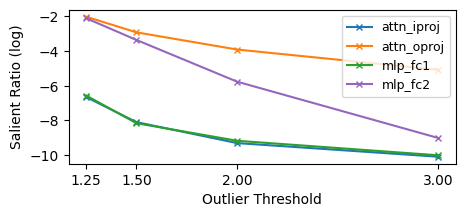

In [50]:
df_threshold = pd.DataFrame(columns=['threshold', 'qkvproj', 'oproj', 'fc1', 'fc2'])

outlier_stats = torch.load('act_stats/opt-6.7b.pt')

layer_type_cast = {
    'q_proj': 'qkvproj',
    'k_proj': 'qkvproj',
    'v_proj': 'qkvproj',
    'out_proj': 'oproj',
    'fc1': 'fc1',
    'fc2': 'fc2',
}

outlier_stats = {k: v for k, v in outlier_stats.items() if not 'norm' in k and not 'matmul' in k}
# outlier_stats = {k: v for k, v in outlier_stats.items() if 'input_layernorm' in k}
# outlier_stats = {k: v for k, v in outlier_stats.items() if 'post_attention_layernorm' in k}
# outlier_stats = {k: v for k, v in outlier_stats.items() if 'self_attn_layer_norm' in k}
# outlier_stats = {k: v for k, v in outlier_stats.items() if 'final_layer_norm' in k}

output_scales = []

for threshold in [1, 1.25, 1.5, 2, 3]:
    layer_type_ratios = {
        'qkvproj': [],
        'oproj': [],
        'fc1': [],
        'fc2': [],
    }

    for module_name, layer_stats in outlier_stats.items():
        input_stats = layer_stats['input']
        input_scale = input_stats['max'] - input_stats['min']
        input_scale_mean = input_scale.mean()
        input_scale_std = input_scale.std()
        input_scale_mid = np.percentile(input_scale, 50)

        # threshold = input_scale_mean * 2
        # threshold = input_scale_mid  * 1.25
        input_scale = input_scale / input_scale_mid

        salient_mask = input_scale > threshold
        salient_ratio = salient_mask.sum() / len(salient_mask)
        # log_salient_ratio = np.log2(salient_ratio)
        # print(module_name, f"salient ratio: {log_salient_ratio:.2f}")
        # print(module_name, f"std / mean: {input_scale_std / input_scale_mean:.2f}")

        layer_type = layer_type_cast[module_name.split('.')[-1]]
        layer_type_ratios[layer_type].append(salient_ratio)

    # get average salient ratio for each layer type
    for layer_type in layer_type_ratios:
        mean_ratio = np.mean(layer_type_ratios[layer_type])
        log2_mean_ratio = np.log2(mean_ratio)
        layer_type_ratios[layer_type] = log2_mean_ratio
    print(layer_type_ratios)

    layer_type_ratios['threshold'] = threshold

    df_threshold.loc[len(df_threshold)] = layer_type_ratios

plt.figure(figsize=(5, 2))

for layer_type in layer_types:
    if layer_type == 'threshold':
        continue
    plt.plot(df_threshold['threshold'][1:], df_threshold[layer_type][1:], 'x-', markersize=5, color=layer_type_colors[layer_type], label=f'{layer_types[layer_type]}')
plt.legend(fontsize=9)
plt.xticks([1.25, 1.5, 2, 3])
plt.xlabel('Outlier Threshold')
plt.ylabel('Salient Ratio (log)')



In [33]:
for model in models:
    if model != 'llama-7b-meta': continue

    # draw an extra line for opt qkvproj 12bit
    if model == 'opt-6.7b':
        df1 = df[df['layer_type'] == 'qkvproj']
        df1 = df1[df1['outlier_precision'] == 12]
        df1 = df1[df1['model'] == model]
        # sort df1 by outlier ratio
        df1 = df1.sort_values(by=['outlier_threshold'])

        outlier_threshold_list = df1['outlier_threshold']
        ppl_list = df1['wikitext2']
        ppl_list.index = range(len(ppl_list))

        df_threshold[f'{layer_type}_ppl'] = ppl_list

    for layer_type in layer_types:
        for outlier_precision in outlier_precisions:
            if model == 'opt-6.7b' and layer_type == 'qkvproj' and outlier_precision == 8:
                continue
            df1 = df[df['layer_type'] == layer_type]
            df1 = df1[df1['outlier_precision'] == outlier_precision]
            df1 = df1[df1['model'] == model]
            # sort df1 by outlier ratio
            df1 = df1.sort_values(by=['outlier_threshold'])
            outlier_threshold_list = df1['outlier_threshold']
            ppl_list = df1['wikitext2']
            ppl_list.index = range(len(ppl_list))
            df_threshold[f'{layer_type}_ppl'] = ppl_list

    
df_threshold.to_csv('results/sensitivity_opt.csv', index=False)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# colormap = mpl.colormaps['Blues']
colormap = mpl.colormaps['RdBu']
for i in range(16):
    r, g, b, a = colormap((2 * i + 1) / 32 * 0.6 + 0.2)
    r = int(r * 256)
    g = int(g * 256)
    b = int(b * 256)
    print(r, g, b)

220 109 87
231 134 106
243 161 127
247 181 150
251 202 178
253 222 203
251 231 220
249 243 239
241 244 246
226 237 243
211 230 241
189 219 235
165 207 228
141 194 221
110 175 210
79 155 200


In [518]:
average_bits_list = []

for stat_path in [
    'act_stats/llama-7b-meta.pt',
    'act_stats/llama-13b-meta.pt',
    'act_stats/llama-30b-meta.pt',
    'act_stats/llama-65b-meta.pt',
    'act_stats/opt-6.7b.pt',
    'act_stats/opt-13b.pt',
    'act_stats/opt-30b.pt',
    'act_stats/opt-66b.pt',
]:

    outlier_stats = torch.load(stat_path)

    if 'llama' in stat_path:
        layer_type_cast = {
            'q_proj': 'qkvproj',
            'k_proj': 'qkvproj',
            'v_proj': 'qkvproj',
            'o_proj': 'oproj',
            'up_proj': 'fc1',
            'gate_proj': 'fc1',
            'down_proj': 'fc2',
        }
    else:
        layer_type_cast = {
            'q_proj': 'qkvproj',
            'k_proj': 'qkvproj',
            'v_proj': 'qkvproj',
            'out_proj': 'oproj',
            'fc1': 'fc1',
            'fc2': 'fc2',
        }

    # for simplicity, we use threshold = 2 and outlier precision = 8
    threshold = 2
    
    normal_bits = 4
    # outlier_bits = 8   # oltron
    outlier_bits = 32  # olaccel

    cnt_salient_channel = 0
    cnt_total_channel = 0

    outlier_stats = {k: v for k, v in outlier_stats.items() if not 'norm' in k and not 'matmul' in k}

    for module_name, layer_stats in outlier_stats.items():
        input_stats = layer_stats['input']
        input_scale = input_stats['max'] - input_stats['min']
        input_scale_mid = np.percentile(input_scale, 50)

        input_scale = input_scale / input_scale_mid
        salient_mask = input_scale > threshold

        cnt_salient_channel += salient_mask.sum()
        cnt_total_channel += len(salient_mask)

    salient_ratio = cnt_salient_channel / cnt_total_channel
    average_bits = salient_ratio * outlier_bits + (1 - salient_ratio) * normal_bits

    print(stat_path, f"{average_bits:.2f}")
    average_bits_list.append(average_bits)

print(np.mean(average_bits_list))

act_stats/llama-7b-meta.pt 4.85
act_stats/llama-13b-meta.pt 4.85
act_stats/llama-30b-meta.pt 4.87
act_stats/llama-65b-meta.pt 4.93
act_stats/opt-6.7b.pt 4.46
act_stats/opt-13b.pt 4.47
act_stats/opt-30b.pt 5.13
act_stats/opt-66b.pt 5.38
4.867154
